In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import gc
from keras.utils import to_categorical


In [3]:
def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/train')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 0
    elif file_name.startswith("task_motor"):
        return 1
    elif file_name.startswith("task_story"):
        return 2
    elif file_name.startswith("task_working"):
        return 3
    else:
        return None

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

fmri_data_folder = find_fmri_data_folder('/content/drive/My Drive')
meg_data_list = []
labels = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_data_list.append(data)
        labels.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_train_data_array = np.stack(meg_data_list, axis=0)
labels_train_array = np.array(labels)

In [4]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 4
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros_like(array)

  for o in range(array.shape[0]):
      for i in range(array.shape[1]):
          array_filtered[o, i, :] = butter_lowpass_filter(array[o, i, :], cutoff_frequency, original_sampling_rate)
  del array
  gc.collect()
  return array_filtered


def apply_downsampling(array):
  n_observations, n_sensors, n_timepoints = array.shape
  downsampling_factor = 4
  new_n_timepoints = n_timepoints // downsampling_factor
  array_downsamp = np.zeros((n_observations, n_sensors, new_n_timepoints))

  for obs in range(n_observations):
    for sensor in range(n_sensors):
      array_downsamp[obs,sensor,:] = array[obs, sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_observations, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp



In [5]:
# per file
def min_max_scaling_per_file(data):
    # Initialize an empty array with the same shape as the input data
    scaled_data = np.zeros_like(data)

    # Iterate over each file
    for file_index in range(data.shape[0]):
        file_data = data[file_index, :, :]

        # Compute the min and max for this file
        min_val = np.min(file_data)
        max_val = np.max(file_data)

        # Apply Min-Max scaling for this file
        scaled_data[file_index, :, :] = (file_data - min_val) / (max_val - min_val) if max_val != min_val else file_data

    return scaled_data

# per sensor
def min_max_scaling_per_sensor(data):
    # Initialize an empty array with the same shape as the input data
    scaled_data = np.zeros_like(data)

    # Iterate over each sensor
    for sensor in range(data.shape[1]):
        # Flatten the data for this sensor across all files and timepoints
        sensor_data = data[:, sensor, :].flatten()

        # Compute the min and max for this sensor
        min_val = np.min(sensor_data)
        max_val = np.max(sensor_data)

        # Apply Min-Max scaling for this sensor
        scaled_data[:, sensor, :] = (data[:, sensor, :] - min_val) / (max_val - min_val)

    return scaled_data



In [6]:
#############################################################################
############################## MIN-MAX SCALING ##############################
#############################################################################

# APPLY SCALING FILTER AND DOWNSAMPLING
array_scaled_min_max = min_max_scaling_per_file(meg_train_data_array)
array_filtered = apply_lowpass(array_scaled_min_max)
del array_scaled_min_max
array_doensampled = apply_downsampling(array_filtered)
del array_filtered





In [7]:
# SEPARATE EACH MOTOR TASK IN DIFFERENT ARRAY

rest_class = array_doensampled[labels_train_array == 0]
motor_class = array_doensampled[labels_train_array == 1]
story_class = array_doensampled[labels_train_array == 2]
working_class = array_doensampled[labels_train_array == 3]

rest_labels = labels_train_array[labels_train_array==0]
motor_labels = labels_train_array[labels_train_array==1]
story_labels = labels_train_array[labels_train_array==2]
working_labels = labels_train_array[labels_train_array==3]


print(rest_class.shape)
print(motor_class.shape)
print(story_class.shape)
print(working_class.shape)

print(rest_labels.shape)
print(motor_labels.shape)
print(story_labels.shape)
print(working_labels.shape)



(8, 248, 8906)
(8, 248, 8906)
(8, 248, 8906)
(8, 248, 8906)
(8,)
(8,)
(8,)
(8,)


In [8]:
# Stacked data

stacked_classes = np.stack((rest_class, motor_class, story_class, working_class))
stacked_labels = np.stack((rest_labels, motor_labels, story_labels, working_labels))

tasks, inst, sensors, timepoints = stacked_classes.shape
stacked_classes = stacked_classes.reshape(tasks*inst, sensors,timepoints)
stacked_labels = stacked_labels.reshape(tasks*inst)

print(stacked_classes.shape)
print(stacked_labels.shape)

(32, 248, 8906)
(32,)


In [9]:
obs, sensors, timepoints = stacked_classes.shape
X_test_repeated = stacked_classes.reshape(obs* sensors, timepoints)
y_train_repeated = np.repeat(stacked_labels, 248, axis=0)

del stacked_classes, stacked_labels, obs, sensors, timepoints, rest_class, motor_class, story_class , working_class , rest_labels , motor_labels , story_labels , working_labels
print(X_test_repeated.shape, y_train_repeated.shape)

(7936, 8906) (7936,)


In [10]:
# SEPARATE EACH MOTOR TASK IN DIFFERENT ARRAY

rest_class = X_test_repeated[y_train_repeated == 0]
motor_class = X_test_repeated[y_train_repeated == 1]
story_class = X_test_repeated[y_train_repeated == 2]
working_class = X_test_repeated[y_train_repeated == 3]

rest_labels = y_train_repeated[y_train_repeated==0]
motor_labels = y_train_repeated[y_train_repeated==1]
story_labels = y_train_repeated[y_train_repeated==2]
working_labels = y_train_repeated[y_train_repeated==3]


print(rest_class.shape)
print(motor_class.shape)
print(story_class.shape)
print(working_class.shape)

print(rest_labels.shape)
print(motor_labels.shape)
print(story_labels.shape)
print(working_labels.shape)



(1984, 8906)
(1984, 8906)
(1984, 8906)
(1984, 8906)
(1984,)
(1984,)
(1984,)
(1984,)


In [11]:
# def plot_task_means(mean_arrays, task_labels, colors):
#     plt.figure(figsize=(18, 8))

#     # Plot an empty line for each task to create the legend
#     for label, color in zip(task_labels, colors):
#         plt.plot([], [], label=label, color=color)

#     # Plot the actual data
#     for mean_array, color in zip(mean_arrays, colors):
#         for line in mean_array:
#             plt.plot(line, color=color, alpha=1)

#     plt.title("Mean Values of Each Task")
#     plt.xlabel("Timepoints")
#     plt.ylabel("Mean Amplitude")
#     plt.legend()
#     plt.show()

# # Example usage remains the same
# mean_arrays = [rest_class[:200], motor_class[:200], story_class[:200], working_class[:200]]
# task_labels = ["Rest", "Motor", "Story", "Working"]
# colors = ["blue", "green", "red", "purple"]

# plot_task_means(mean_arrays, task_labels, colors)


# del mean_arrays, task_labels, colors

In [12]:
del rest_class,motor_class,story_class,working_class, rest_labels, motor_labels,story_labels,working_labels


In [13]:
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(8906, 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [14]:
X_train_reshaped = X_test_repeated.reshape((X_test_repeated.shape[0], X_test_repeated.shape[1], 1))

history = model.fit(
    X_train_reshaped, y_train_repeated,
    batch_size=32,
    epochs=4,
    validation_split=0.2,
    verbose=1
)

Epoch 1/4
199/199 [==============================] - 403s 2s/step - loss: 1.4456 - accuracy: 0.3672 - val_loss: 2.6837 - val_accuracy: 0.0000e+00
Epoch 2/4
199/199 [==============================] - 390s 2s/step - loss: 1.2255 - accuracy: 0.3978 - val_loss: 2.6984 - val_accuracy: 0.0000e+00
Epoch 3/4
199/199 [==============================] - 386s 2s/step - loss: 1.1919 - accuracy: 0.4121 - val_loss: 2.1294 - val_accuracy: 0.0000e+00
Epoch 4/4
199/199 [==============================] - 389s 2s/step - loss: 1.1654 - accuracy: 0.4342 - val_loss: 3.3752 - val_accuracy: 0.0000e+00


In [15]:
del X_train_reshaped

In [16]:
################ TEST DATA ####################

# Retrieve Test data

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/test')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 0
    elif file_name.startswith("task_motor"):
        return 1
    elif file_name.startswith("task_story"):
        return 2
    elif file_name.startswith("task_working"):
        return 3
    else:
        return None

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

fmri_data_folder = find_fmri_data_folder('/content/drive/My Drive')
meg_test_data_list = []
labels_test = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_test_data_list.append(data)
        labels_test.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_test_data_array = np.stack(meg_test_data_list, axis=0)
labels_test_array = np.array(labels_test)



In [17]:
meg_test_data_array.shape

(8, 248, 35624)

In [18]:
labels_test_array

array([1, 3, 2, 2, 1, 0, 3, 0])

In [19]:
#############################################################################
############################## MIN-MAX SCALING ##############################
#############################################################################

# APPLY SCALING FILTER AND DOWNSAMPLING
array_scaled_min_max = min_max_scaling_per_file(meg_test_data_array)
array_filtered = apply_lowpass(array_scaled_min_max)
del array_scaled_min_max
array_doensampled = apply_downsampling(array_filtered)
del array_filtered

# SEPARATE EACH MOTOR TASK IN DIFFERENT ARRAY

rest_class = array_doensampled[labels_test_array == 0]
motor_class = array_doensampled[labels_test_array == 1]
story_class = array_doensampled[labels_test_array == 2]
working_class = array_doensampled[labels_test_array == 3]

rest_labels = labels_test_array[labels_test_array==0]
motor_labels = labels_test_array[labels_test_array==1]
story_labels = labels_test_array[labels_test_array==2]
working_labels = labels_test_array[labels_test_array==3]


print(rest_class.shape)
print(motor_class.shape)
print(story_class.shape)
print(working_class.shape)



(2, 248, 8906)
(2, 248, 8906)
(2, 248, 8906)
(2, 248, 8906)


In [20]:
# Stacked data

stacked_classes = np.stack((rest_class, motor_class, story_class, working_class))
stacked_labels = np.stack((rest_labels, motor_labels, story_labels, working_labels))

tasks, inst, sensors, timepoints = stacked_classes.shape
stacked_classes = stacked_classes.reshape(tasks*inst, sensors,timepoints)
stacked_labels = stacked_labels.reshape(tasks*inst)

print(stacked_classes.shape)
print(stacked_labels.shape)

(8, 248, 8906)
(8,)


In [21]:
obs, sensors, timepoints = stacked_classes.shape
X_test_repeated = stacked_classes.reshape(obs* sensors, timepoints)
y_test_repeated = np.repeat(stacked_labels, 248, axis=0)

del stacked_classes, stacked_labels, obs, sensors, timepoints, rest_class, motor_class, story_class , working_class , rest_labels , motor_labels , story_labels , working_labels
print(X_test_repeated.shape, y_test_repeated.shape)

(1984, 8906) (1984,)


In [22]:
X_test_reshaped = X_test_repeated.reshape((X_test_repeated.shape[0], X_test_repeated.shape[1], 1))
del X_test_repeated

In [23]:
# Predict classes or probabilities
y_pred = model.predict(X_test_reshaped)

# Assuming it's a classification problem with multiple classes
y_pred_classes = np.argmax(y_pred, axis=1)


62/62 [==============================] - 24s 388ms/step


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Assuming y_test is already in the correct shape (num_samples,) and label encoded
test_accuracy = accuracy_score(y_test_repeated, y_pred_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Detailed classification report
print(classification_report(y_test_repeated, y_pred_classes))


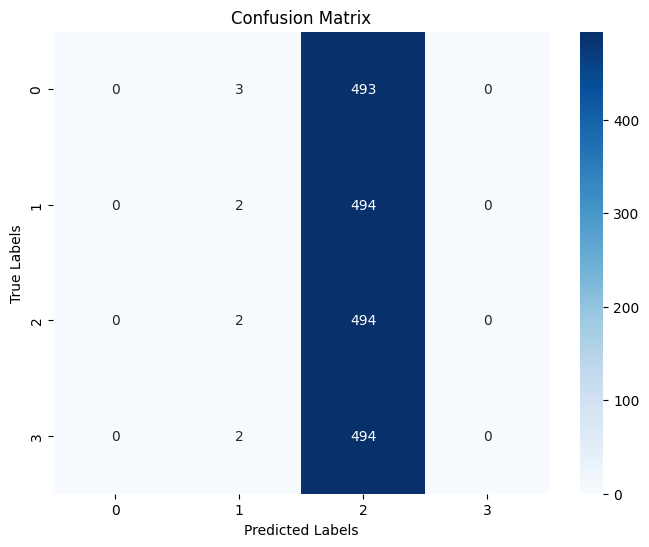

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_repeated, y_pred_classes)

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
